In [2]:
# Cell 1: Setup
import os, json, math, random, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, average_precision_score, roc_auc_score

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paths (edit PROJ if your project root differs)
PROJ   = Path.cwd()                  # or Path(r"C:\Users\nikhi\Music\ECG")
DATA   = PROJ / "data"
PREP   = PROJ / "prepared"
RESULTS= PROJ / "results"
FIGS   = PROJ / "figures"
for p in [RESULTS, FIGS, PROJ / "models", PREP]: p.mkdir(exist_ok=True, parents=True)

print("TensorFlow:", tf.__version__)
print("Project dir:", PROJ)
physical = tf.config.list_physical_devices("GPU")
print("GPU(s):", physical if physical else "None detected")

# (Optional) mixed precision if GPU
if physical:
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy("mixed_float16")
        print("Mixed precision enabled.")
    except Exception as e:
        print("Mixed precision not enabled:", e)


TensorFlow: 2.20.0
Project dir: C:\Users\nikhi\Music\ECG
GPU(s): None detected


In [3]:
# Cell 2: Load prepared arrays saved in Phase 2
X_train = np.load(PREP / "X_train_balanced_dl.npy")  # shape: [N, 187, 1]
X_val   = np.load(PREP / "X_val_dl.npy")
X_test  = np.load(PREP / "X_test_dl.npy")

y_train = np.load(PREP / "y_train_balanced.npy")
y_val   = np.load(PREP / "y_val.npy")
y_test  = np.load(PREP / "y_test.npy")

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)

NUM_CLASSES = 5
INPUT_LEN   = X_train.shape[1]
CHANNELS    = X_train.shape[2]
assert INPUT_LEN == 187 and CHANNELS == 1, "Expecting beats of length 187 with 1 channel."


Train: (80032, 187, 1) (80032,)
Val  : (8756, 187, 1) (8756,)
Test : (21892, 187, 1) (21892,)


In [4]:
# Cell 3: Load class weights computed earlier (Phase 2)
cw_path = PREP / "class_weight.json"
if cw_path.exists():
    with open(cw_path) as f:
        class_weight = {int(k): float(v) for k, v in json.load(f).items()}
else:
    # fallback: inverse frequency from y_train
    from collections import Counter
    ctr = Counter(y_train.tolist()); tot = sum(ctr.values())
    class_weight = {c: tot / (NUM_CLASSES * ctr[c]) for c in range(NUM_CLASSES)}
print("Class weights:", class_weight)


Class weights: {0: 0.24541036137558836, 1: 7.9992003998001, 2: 3.0728354770589363, 3: 8.838431805632247, 4: 2.765445749827229}


In [6]:
# Cell 4 (patch): make timeshift robust and fix static shape after map

import tensorflow as tf

BATCH_SIZE = 256
AUTOTUNE   = tf.data.AUTOTUNE

@tf.function
def aug_timeshift(x, max_shift=3):
    # circular roll by an integer in [-max_shift, max_shift]
    s = tf.random.uniform([], minval=-max_shift, maxval=max_shift+1, dtype=tf.int32)
    return tf.roll(x, shift=s, axis=0)

@tf.function
def aug_jitter(x, sigma=0.01):
    noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=sigma, dtype=x.dtype)
    return x + noise

def train_map_fn(x, y):
    # x: (187,1) expected
    x = tf.squeeze(x, axis=-1)  # (187,)
    # subtle, probabilistic augs
    x = tf.cond(tf.random.uniform([]) < 0.5, lambda: aug_timeshift(x), lambda: x)
    x = tf.cond(tf.random.uniform([]) < 0.5, lambda: aug_jitter(x),   lambda: x)
    x = tf.expand_dims(x, -1)   # (187,1)
    x = tf.cast(x, tf.float32)
    x.set_shape([187, 1])       # <- important: make static for Keras
    return x, y

def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(min(len(y), 20000), seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(train_map_fn, num_parallel_calls=AUTOTUNE)
    else:
        # for val/test we ensure static shape too
        def setshape(x, y):
            x = tf.cast(x, tf.float32)
            x.set_shape([187, 1])
            return x, y
        ds = ds.map(setshape, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

ds_train = make_ds(X_train, y_train, training=True)
ds_val   = make_ds(X_val,   y_val,   training=False)
ds_test  = make_ds(X_test,  y_test,  training=False)

ds_train, ds_val


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [9]:
# Cell 5: Baseline 1D-CNN for ECG classification (simple & justifiable)

from tensorflow import keras
from tensorflow.keras import layers

def conv_block(x, filters, kernel_size, stride=1, name=None):
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding="same",
                      use_bias=False, name=None if not name else name+"_conv")(x)
    x = layers.BatchNormalization(name=None if not name else name+"_bn")(x)
    x = layers.Activation("relu", name=None if not name else name+"_relu")(x)
    return x

def build_ecg_cnn_baseline(input_len=187, channels=1, n_classes=5, base=32, dropout=0.2):
    inp = layers.Input(shape=(input_len, channels))

    # Block 1: captures QRS and nearby P/T morphology
    x = conv_block(inp, base, kernel_size=7, stride=1, name="block1")
    x = conv_block(x,   base, kernel_size=7, stride=2, name="block1_down")

    # Block 2: deeper temporal features
    x = conv_block(x, base*2, kernel_size=5, stride=1, name="block2")
    x = conv_block(x, base*2, kernel_size=5, stride=2, name="block2_down")

    # Block 3: fine-level waveform patterns
    x = conv_block(x, base*4, kernel_size=3, stride=1, name="block3")

    # Regularization + global context
    x = layers.Dropout(dropout, name="dropout")(x)
    x = layers.GlobalAveragePooling1D(name="gap")(x)

    # Classifier
    out = layers.Dense(n_classes, activation="softmax", dtype="float32", name="output")(x)
    return keras.Model(inputs=inp, outputs=out, name="ECG_CNN_Baseline")


In [10]:
# Cell 6: Build and summarize the model
model = build_ecg_cnn_baseline(
    input_len=INPUT_LEN,
    channels=CHANNELS,
    n_classes=NUM_CLASSES,
    base=32,
    dropout=0.2
)
model.summary()


Model: "ECG_CNN_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv (Conv1D)                 │ (None, 187, 32)             │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_bn (BatchNormalization)       │ (None, 187, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_relu (Activation)             │ (None, 187, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_down_conv (Conv1D)            │ (None, 94, 32)              │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_down_bn (BatchNormalization)  │ (None, 94, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_down_relu (Activation)        │ (None, 94, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv (Conv1D)                 │ (None, 94, 64)              │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_bn (BatchNormalization)       │ (None, 94, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_relu (Activation)             │ (None, 94, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_down_conv (Conv1D)            │ (None, 47, 64)              │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_down_bn (BatchNormalization)  │ (None, 47, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_down_relu (Activation)        │ (None, 47, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv (Conv1D)                 │ (None, 47, 128)             │          24,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_bn (BatchNormalization)       │ (None, 47, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_relu (Activation)             │ (None, 47, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gap (GlobalAveragePooling1D)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,613 (252.39 KB)

 Trainable params: 63,973 (249.89 KB)

 Non-trainable params: 640 (2.50 KB)

In [11]:
# Cell 7: Compile model and set callbacks

from tensorflow import keras

LR_BASE = 1e-3
model.compile(
    optimizer=keras.optimizers.Adam(LR_BASE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

ckpt_path = PROJ / "models" / "ecg_cnn_baseline_best.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=ckpt_path.as_posix(),
                                    monitor="val_acc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max",
                                  patience=8, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4,
                                      min_lr=1e-6, verbose=1)
]
print("Checkpoint will be saved to:", ckpt_path)


Checkpoint will be saved to: C:\Users\nikhi\Music\ECG\models\ecg_cnn_baseline_best.keras


In [12]:
# Cell 8: Train baseline CNN
EPOCHS = 40   # early stopping usually halts sooner

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - acc: 0.5608 - loss: 0.8323
Epoch 1: val_acc improved from None to 0.42736, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_baseline_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 288ms/step - acc: 0.6620 - loss: 0.6271 - val_acc: 0.4274 - val_loss: 1.2583 - learning_rate: 0.0010
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - acc: 0.7965 - loss: 0.4143
Epoch 2: val_acc improved from 0.42736 to 0.84388, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_baseline_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 280ms/step - acc: 0.8029 - loss: 0.4012 - val_acc: 0.8439 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - acc: 0.8251 - loss: 0.3598
Epoch 3: val_acc improved from 0.84388 to 0.86980, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_baseline_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 283ms/step - acc: 0.8288 - loss: 0.3416 - val_acc: 0.8698 - val_loss: 0.

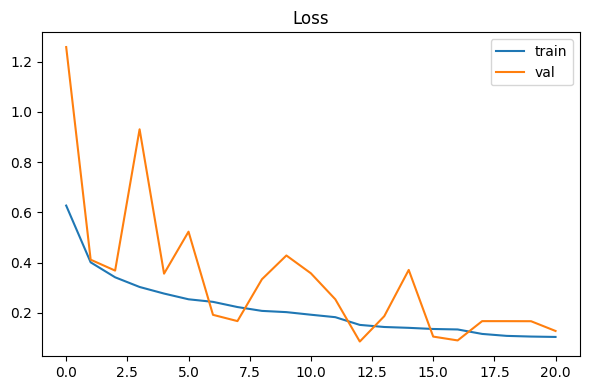

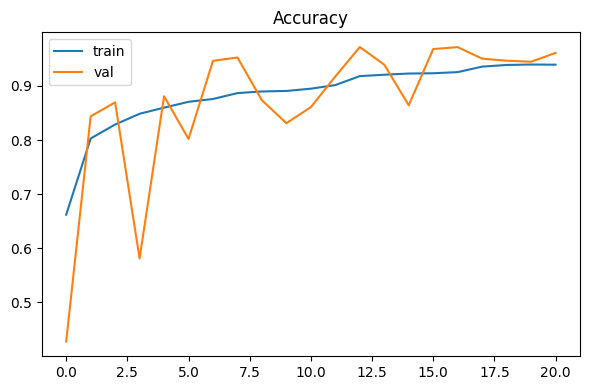

In [13]:
# Cell 9: Learning curves
hist = history.history

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["acc"], label="train")
plt.plot(hist["val_acc"], label="val")
plt.title("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()


[VAL] macro-F1: 0.8544616704538663
              precision    recall  f1-score   support

           N     0.9814    0.9884    0.9849      7248
           S     0.8553    0.6126    0.7139       222
           V     0.9560    0.8998    0.9270       579
           F     0.5278    0.8906    0.6628        64
           Q     0.9829    0.9844    0.9837       643

    accuracy                         0.9720      8756
   macro avg     0.8607    0.8752    0.8545      8756
weighted avg     0.9733    0.9720    0.9717      8756



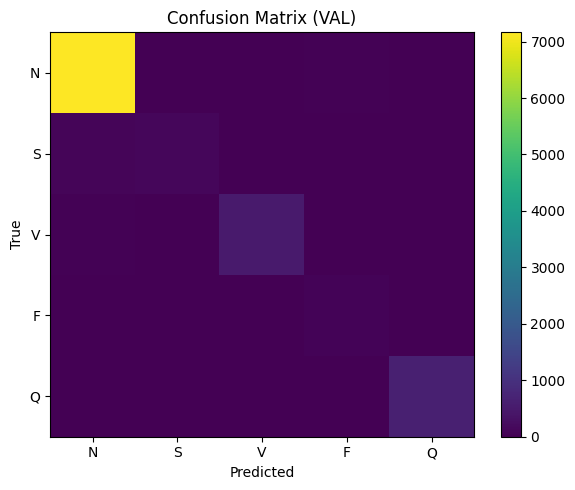

[VAL] PR-AUC(macro): 0.9199 | ROC-AUC(macro): 0.9933


In [14]:
# Cell 10: Validation evaluation
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

proba_val = model.predict(ds_val, verbose=0)
y_val_pred = proba_val.argmax(axis=1)

print("[VAL] macro-F1:", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, target_names=["N","S","V","F","Q"], digits=4))

cm_val = confusion_matrix(y_val, y_val_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(6,5))
plt.imshow(cm_val, aspect='auto')
plt.title("Confusion Matrix (VAL)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
plt.colorbar(); plt.tight_layout(); plt.show()

# PR-AUC & ROC-AUC (macro) — may skip if any class has degenerate probs
try:
    ap_macro = average_precision_score(y_val, proba_val, average="macro")
    roc_macro = roc_auc_score(y_val, proba_val, multi_class="ovr", average="macro")
    print(f"[VAL] PR-AUC(macro): {ap_macro:.4f} | ROC-AUC(macro): {roc_macro:.4f}")
except Exception as e:
    print("AUC computations skipped:", e)


[TEST] macro-F1: 0.8454492651027585
              precision    recall  f1-score   support

           N     0.9794    0.9887    0.9840     18118
           S     0.7957    0.6025    0.6858       556
           V     0.9497    0.8867    0.9171      1448
           F     0.5233    0.9012    0.6621       162
           Q     0.9961    0.9608    0.9782      1608

    accuracy                         0.9694     21892
   macro avg     0.8489    0.8680    0.8454     21892
weighted avg     0.9707    0.9694    0.9692     21892



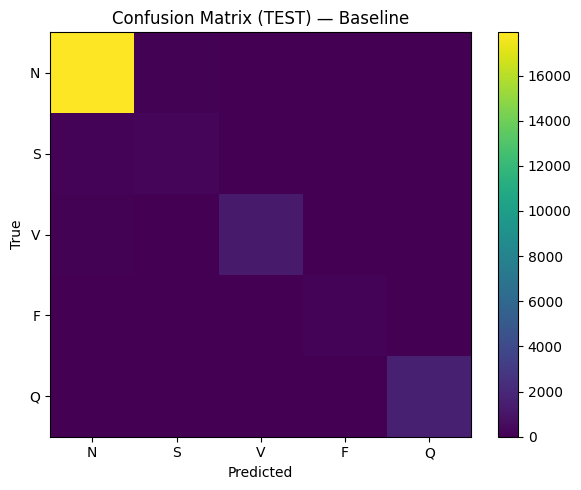

In [15]:
# Cell 11: Test evaluation (baseline)
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

proba_test = model.predict(ds_test, verbose=0)
y_test_pred = proba_test.argmax(axis=1)

print("[TEST] macro-F1:", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, target_names=["N","S","V","F","Q"], digits=4))

cm_test = confusion_matrix(y_test, y_test_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(6,5))
plt.imshow(cm_test, aspect='auto')
plt.title("Confusion Matrix (TEST) — Baseline")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
plt.colorbar(); plt.tight_layout(); plt.show()


In [16]:
# Cell 12: Save baseline artifacts
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report

Path(PROJ / "models").mkdir(exist_ok=True)

# Save final model (best already saved by checkpoint)
model.save(PROJ / "models" / "ecg_cnn_baseline_last.keras")

# Save predictions
np.save(RESULTS / "cnn_baseline_val_pred.npy",  y_val_pred)
np.save(RESULTS / "cnn_baseline_test_pred.npy", y_test_pred)

# Save text reports
rep_val  = classification_report(y_val,  y_val_pred,  target_names=["N","S","V","F","Q"], digits=4)
rep_test = classification_report(y_test, y_test_pred, target_names=["N","S","V","F","Q"], digits=4)
with open(RESULTS / "cnn_baseline_report_val.txt", "w") as f: f.write(rep_val)
with open(RESULTS / "cnn_baseline_report_test.txt", "w") as f: f.write(rep_test)

print("Saved baseline model & reports.")


Saved baseline model & reports.


In [19]:
# Updated Cell 5: Baseline 1D-CNN with optional dense head after GAP

from tensorflow import keras
from tensorflow.keras import layers, regularizers

def conv_block(x, filters, kernel_size, stride=1, name=None):
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding="same",
                      use_bias=False, name=None if not name else name+"_conv")(x)
    x = layers.BatchNormalization(name=None if not name else name+"_bn")(x)
    x = layers.Activation("relu", name=None if not name else name+"_relu")(x)
    return x

def build_ecg_cnn_baseline(
    input_len=187, channels=1, n_classes=5, base=32, dropout=0.2,
    head_units=64,          # set to 0 to disable dense head
    head_dropout=0.30,
    head_l2=1e-4
):
    inp = layers.Input(shape=(input_len, channels))

    # Convolutional feature extractor (same as before)
    x = conv_block(inp, base,   kernel_size=7, stride=1, name="block1")
    x = conv_block(x,  base,   kernel_size=7, stride=2, name="block1_down")
    x = conv_block(x,  base*2, kernel_size=5, stride=1, name="block2")
    x = conv_block(x,  base*2, kernel_size=5, stride=2, name="block2_down")
    x = conv_block(x,  base*4, kernel_size=3, stride=1, name="block3")

    # Regularization + global context
    x = layers.Dropout(dropout, name="dropout")(x)
    x = layers.GlobalAveragePooling1D(name="gap")(x)

    # Optional dense head
    if head_units and head_units > 0:
        x = layers.Dense(
            head_units,
            kernel_regularizer=regularizers.l2(head_l2),
            use_bias=False,
            name="head_dense"
        )(x)
        x = layers.BatchNormalization(name="head_bn")(x)
        x = layers.Activation("relu", name="head_relu")(x)
        x = layers.Dropout(head_dropout, name="head_dropout")(x)

    out = layers.Dense(n_classes, activation="softmax", dtype="float32", name="output")(x)
    return keras.Model(inputs=inp, outputs=out, name="ECG_CNN_Baseline_HEAD")


In [20]:
# Updated Cell 6: Build & summarize with a small dense head
model = build_ecg_cnn_baseline(
    input_len=INPUT_LEN,
    channels=CHANNELS,
    n_classes=NUM_CLASSES,
    base=32,
    dropout=0.2,
    head_units=64,        # try 64 first; 0 disables the head
    head_dropout=0.30,
    head_l2=1e-4
)
model.summary()


Model: "ECG_CNN_Baseline_HEAD"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv (Conv1D)                 │ (None, 187, 32)             │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_bn (BatchNormalization)       │ (None, 187, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_relu (Activation)             │ (None, 187, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_down_conv (Conv1D)            │ (None, 94, 32)              │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_down_bn (BatchNormalization)  │ (None, 94, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_down_relu (Activation)        │ (None, 94, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv (Conv1D)                 │ (None, 94, 64)              │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_bn (BatchNormalization)       │ (None, 94, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_relu (Activation)             │ (None, 94, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_down_conv (Conv1D)            │ (None, 47, 64)              │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_down_bn (BatchNormalization)  │ (None, 47, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_down_relu (Activation)        │ (None, 47, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv (Conv1D)                 │ (None, 47, 128)             │          24,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_bn (BatchNormalization)       │ (None, 47, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_relu (Activation)             │ (None, 47, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gap (GlobalAveragePooling1D)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_dense (Dense)                   │ (None, 64)                  │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_bn (BatchNormalization)         │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_relu (Activation)               │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 72,741 (284.14 KB)

 Trainable params: 71,973 (281.14 KB)

 Non-trainable params: 768 (3.00 KB)

In [21]:
# Cell 7: Compile model and set callbacks 

from tensorflow import keras

LR_BASE = 1e-3
model.compile(
    optimizer=keras.optimizers.Adam(LR_BASE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

ckpt_path = PROJ / "models" / "ecg_cnn_baseline_head_best.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path.as_posix(),
        monitor="val_acc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(
        monitor="val_acc", mode="max",
        patience=8, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=4,
        min_lr=1e-6, verbose=1)
]

print("Checkpoint will be saved to:", ckpt_path)


Checkpoint will be saved to: C:\Users\nikhi\Music\ECG\models\ecg_cnn_baseline_head_best.keras


In [22]:
# Cell 8: Train baseline CNN with dense head

EPOCHS = 40   # early stopping will usually trigger before this

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weight,   # handles class imbalance
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - acc: 0.4747 - loss: 0.9160
Epoch 1: val_acc improved from None to 0.11661, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_baseline_head_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 295ms/step - acc: 0.6019 - loss: 0.6923 - val_acc: 0.1166 - val_loss: 1.9443 - learning_rate: 0.0010
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - acc: 0.7600 - loss: 0.4670
Epoch 2: val_acc improved from 0.11661 to 0.90555, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_baseline_head_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 286ms/step - acc: 0.7761 - loss: 0.4432 - val_acc: 0.9056 - val_loss: 0.3688 - learning_rate: 0.0010
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - acc: 0.8188 - loss: 0.3809
Epoch 3: val_acc did not improve from 0.90555
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - acc: 0.8241 - loss: 0.3705 - val_acc: 0.8902 - val_loss: 0.3514 - learning_rate: 0.0010
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0

In [23]:
# Compare GAP-only vs Dense-head on VAL and TEST
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report

# Paths saved earlier
path_gap_best   = PROJ / "models" / "ecg_cnn_baseline_best.keras"        # from your first baseline run (no dense head)
path_head_best  = PROJ / "models" / "ecg_cnn_baseline_head_best.keras"   # from the dense-head run

m_gap  = load_model(path_gap_best)
m_head = load_model(path_head_best)

def eval_model(m, dsV, yV, dsT, yT, tag):
    proba_val  = m.predict(dsV, verbose=0)
    proba_test = m.predict(dsT, verbose=0)
    ypv = proba_val.argmax(axis=1)
    ypt = proba_test.argmax(axis=1)

    macro_val  = f1_score(yV, ypv, average="macro")
    macro_test = f1_score(yT, ypt, average="macro")

    # Per-class F1 (nice for S/F comparison)
    def per_class_f1(ytrue, ypred):
        return [
            f1_score((ytrue==c).astype(int), (ypred==c).astype(int), zero_division=0)
            for c in range(5)
        ]
    f1v = per_class_f1(yV, ypv)
    f1t = per_class_f1(yT, ypt)

    return {
        "variant": tag,
        "val_macro_f1": macro_val,
        "test_macro_f1": macro_test,
        "val_f1_N": f1v[0], "val_f1_S": f1v[1], "val_f1_V": f1v[2], "val_f1_F": f1v[3], "val_f1_Q": f1v[4],
        "test_f1_N": f1t[0], "test_f1_S": f1t[1], "test_f1_V": f1t[2], "test_f1_F": f1t[3], "test_f1_Q": f1t[4],
    }, (ypv, ypt)

res_gap, _  = eval_model(m_gap,  ds_val, y_val, ds_test, y_test, "baseline_gap")
res_head, _ = eval_model(m_head, ds_val, y_val, ds_test, y_test, "baseline_dense")

df = pd.DataFrame([res_gap, res_head]).round(4)
display(df[["variant","val_macro_f1","test_macro_f1","val_f1_S","val_f1_F","test_f1_S","test_f1_F"]])
display(df)


,variant,val_macro_f1,test_macro_f1,val_f1_S,val_f1_F,test_f1_S,test_f1_F
0,baseline_gap,0.8545,0.8454,0.7139,0.6628,0.6858,0.6621
1,baseline_dense,0.8485,0.8421,0.7844,0.5550,0.7385,0.5731


,variant,val_macro_f1,test_macro_f1,val_f1_N,val_f1_S,val_f1_V,val_f1_F,val_f1_Q,test_f1_N,test_f1_S,test_f1_V,test_f1_F,test_f1_Q
0,baseline_gap,0.8545,0.8454,0.9849,0.7139,0.9270,0.6628,0.9837,0.984,0.6858,0.9171,0.6621,0.9782
1,baseline_dense,0.8485,0.8421,0.9846,0.7844,0.9302,0.5550,0.9883,0.984,0.7385,0.9267,0.5731,0.9881


In [24]:
# Cell 15: SE + Depthwise-Separable residual blocks

from tensorflow import keras
from tensorflow.keras import layers

def se_block(x, r=8, name=None):
    ch = x.shape[-1]
    s = layers.GlobalAveragePooling1D(name=None if not name else name+"_gap")(x)
    s = layers.Dense(max(ch//r,1), activation="relu", name=None if not name else name+"_fc1")(s)
    s = layers.Dense(ch, activation="sigmoid", name=None if not name else name+"_fc2")(s)
    s = layers.Reshape((1, ch))(s)
    return layers.Multiply(name=None if not name else name+"_scale")([x, s])

def ds_res_block(x, filters, kernel_size, stride=1, name=None):
    shortcut = x
    x = layers.SeparableConv1D(filters, kernel_size, strides=stride, padding="same",
                               use_bias=False, name=None if not name else name+"_sep")(x)
    x = layers.BatchNormalization(name=None if not name else name+"_bn")(x)
    x = layers.Activation("relu", name=None if not name else name+"_relu")(x)
    x = se_block(x, name=None if not name else name+"_se")

    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding="same",
                                 use_bias=False, name=None if not name else name+"_proj")(shortcut)
        shortcut = layers.BatchNormalization(name=None if not name else name+"_proj_bn")(shortcut)

    out = layers.Add(name=None if not name else name+"_add")([shortcut, x])
    out = layers.Activation("relu", name=None if not name else name+"_out_relu")(out)
    return out


In [25]:
# Cell 16: Advanced ECG CNN (compact SE-DS-Res)
from tensorflow.keras import layers, Model

def build_ecg_cnn_adv(input_len=187, channels=1, n_classes=5, width=64, dropout=0.15):
    inp = layers.Input(shape=(input_len, channels))

    # Stem: wide kernels capture morphology windows at 125 Hz
    x = layers.Conv1D(width, kernel_size=15, strides=1, padding="same", use_bias=False, name="stem_conv")(inp)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = layers.Activation("relu", name="stem_relu")(x)

    x = layers.Conv1D(width, kernel_size=7, strides=2, padding="same", use_bias=False, name="down1_conv")(x)
    x = layers.BatchNormalization(name="down1_bn")(x)
    x = layers.Activation("relu", name="down1_relu")(x)

    x = ds_res_block(x, filters=width,   kernel_size=7, stride=1, name="b1")
    x = ds_res_block(x, filters=width*2, kernel_size=7, stride=2, name="b2")
    x = ds_res_block(x, filters=width*2, kernel_size=5, stride=1, name="b3")
    x = ds_res_block(x, filters=width*4, kernel_size=3, stride=2, name="b4")
    x = ds_res_block(x, filters=width*4, kernel_size=3, stride=1, name="b5")

    x = layers.Dropout(dropout, name="dropout")(x)
    x = layers.GlobalAveragePooling1D(name="gap")(x)

    out = layers.Dense(n_classes, activation="softmax", dtype="float32", name="output")(x)
    return Model(inp, out, name="ECG_CNN_Advanced")

model_adv = build_ecg_cnn_adv(INPUT_LEN, CHANNELS, NUM_CLASSES, width=64, dropout=0.15)
model_adv.summary()


Model: "ECG_CNN_Advanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 187, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv1D)            │ (None, 187, 64)           │             960 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 187, 64)           │             256 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_relu (Activation)        │ (None, 187, 64)           │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ down1_conv (Conv1D)           │ (None, 94, 64)            │          28,672 │ stem_relu[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ down1_bn (BatchNormalization) │ (None, 94, 64)            │             256 │ down1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ down1_relu (Activation)       │ (None, 94, 64)            │               0 │ down1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ b1_sep (SeparableConv1D)      │ (None, 94, 64)            │           4,544 │ down1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ b1_bn (BatchNormalization)    │ (None, 94, 64)            │             256 │ b1_sep[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ b1_relu (Activation)          │ (None, 94, 64)            │               0 │ b1_bn[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ b1_se_gap                     │ (None, 64)                │               0 │ b1_relu[0][0]              │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ b1_se_fc1 (Dense)             │ (None, 8)                 │             520 │ b1_se_gap[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ b1_se_fc2 (Dense)             │ (None, 64)                │             576 │ b1_se_fc1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_10 (Reshape)          │ (None, 1, 64)             │               0 │ b1_se_fc2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ b1_se_scale (Multiply)        │ (None, 94, 64)            │               0 │ b1_relu[0][0],             │
│                               │                           │                 │ reshape_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ b1_add (Add)                  │ (None, 94, 64)            │               0 │ down1_relu[0][0],          │
│                               │                           │               

 Total params: 249,837 (975.93 KB)

 Trainable params: 247,149 (965.43 KB)

 Non-trainable params: 2,688 (10.50 KB)

In [26]:
# Cell 17: Compile advanced model
from tensorflow import keras

LR_BASE_ADV = 1e-3
model_adv.compile(
    optimizer=keras.optimizers.Adam(LR_BASE_ADV),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

ckpt_adv = PROJ / "models" / "ecg_cnn_advanced_best.keras"
callbacks_adv = [
    keras.callbacks.ModelCheckpoint(filepath=ckpt_adv.as_posix(),
                                    monitor="val_acc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max",
                                  patience=10, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5,
                                      min_lr=1e-6, verbose=1)
]
print("Advanced checkpoint:", ckpt_adv)


Advanced checkpoint: C:\Users\nikhi\Music\ECG\models\ecg_cnn_advanced_best.keras


In [27]:
# Cell 18: Train advanced model
EPOCHS_ADV = 60  # early stop will kick in
history_adv = model_adv.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS_ADV,
    class_weight=class_weight,
    callbacks=callbacks_adv,
    verbose=1
)

# Quick validation metrics
from sklearn.metrics import f1_score, classification_report
proba_val_adv = model_adv.predict(ds_val, verbose=0)
y_val_pred_adv = proba_val_adv.argmax(axis=1)
print("[VAL Advanced] macro-F1:", f1_score(y_val, y_val_pred_adv, average="macro"))
print(classification_report(y_val, y_val_pred_adv, target_names=["N","S","V","F","Q"], digits=4))


Epoch 1/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - acc: 0.5824 - loss: 0.7829
Epoch 1: val_acc improved from None to 0.07104, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_advanced_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - acc: 0.6914 - loss: 0.5753 - val_acc: 0.0710 - val_loss: 2.9352 - learning_rate: 0.0010
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - acc: 0.8217 - loss: 0.3584
Epoch 2: val_acc improved from 0.07104 to 0.74909, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_advanced_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 302ms/step - acc: 0.8325 - loss: 0.3441 - val_acc: 0.7491 - val_loss: 0.6793 - learning_rate: 0.0010
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - acc: 0.8534 - loss: 0.3003
Epoch 3: val_acc did not improve from 0.74909
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 296ms/step - acc: 0.8642 - loss: 0.2841 - val_acc: 0.3443 - val_loss: 1.8274 - learning_rate: 0.0010
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/st

In [28]:
# Cell 19: Load best advanced model & compute val/test probabilities

from tensorflow.keras.models import load_model
import numpy as np

ckpt_adv = PROJ / "models" / "ecg_cnn_advanced_best.keras"
model_adv_best = load_model(ckpt_adv)
print("Loaded:", ckpt_adv)

proba_val_adv  = model_adv_best.predict(ds_val,  verbose=0)  # shape: [N_val, 5]
proba_test_adv = model_adv_best.predict(ds_test, verbose=0)

# Also keep argmax baselines
y_val_pred_adv_argmax  = proba_val_adv.argmax(axis=1)
y_test_pred_adv_argmax = proba_test_adv.argmax(axis=1)


Loaded: C:\Users\nikhi\Music\ECG\models\ecg_cnn_advanced_best.keras


In [29]:
# Cell 20: Temperature scaling (single scalar T) — calibrate probabilities on VAL

import numpy as np

EPS = 1e-12

def softmax_with_temp(logits, T):
    z = logits / T
    z -= z.max(axis=1, keepdims=True)   # numeric stability
    e = np.exp(z)
    return e / np.clip(e.sum(axis=1, keepdims=True), EPS, None)

def probs_to_logits(p):
    p = np.clip(p, EPS, 1.0)
    # logits = log(p) + constant; the constant cancels in softmax with temperature,
    # so plain log(p) works for optimizing T.
    return np.log(p)

def nll_from_probs(p, y):
    p = np.clip(p, EPS, 1.0)
    return float(-np.log(p[np.arange(len(y)), y]).mean())

# Optimize T by simple line search (robust & fast)
logits_val = probs_to_logits(proba_val_adv)
y_val_arr  = y_val.copy()

Ts = np.linspace(0.6, 2.5, 40)
best_T, best_nll = 1.0, nll_from_probs(proba_val_adv, y_val_arr)
for T in Ts:
    pT = softmax_with_temp(logits_val, T)
    nll = nll_from_probs(pT, y_val_arr)
    if nll < best_nll:
        best_T, best_nll = T, nll

print(f"Chosen temperature T={best_T:.3f} (VAL NLL improved to {best_nll:.4f})")

# Calibrated probs
proba_val_cal = softmax_with_temp(logits_val, best_T)
logits_test   = probs_to_logits(proba_test_adv)
proba_test_cal= softmax_with_temp(logits_test, best_T)


Chosen temperature T=1.282 (VAL NLL improved to 0.0523)


In [30]:
# Cell 21: Per-class threshold tuning on VAL (with calibrated probabilities)

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

grid = np.linspace(0.10, 0.90, 33)

def predict_with_thresholds(proba, thr):
    # argmax baseline, then override if any class crosses its own threshold
    arg = proba.argmax(axis=1)
    y_pred = arg.copy()
    for i in range(proba.shape[0]):
        hits = np.where(proba[i] >= thr)[0]
        if len(hits) == 1:
            y_pred[i] = hits[0]
        elif len(hits) > 1:
            y_pred[i] = hits[np.argmax(proba[i, hits])]
    return y_pred

# Baselines
from sklearn.metrics import classification_report
macro_argmax = f1_score(y_val, y_val_pred_adv_argmax, average="macro")
macro_cal_argmax = f1_score(y_val, proba_val_cal.argmax(axis=1), average="macro")
print(f"[VAL] macro-F1 argmax (raw): {macro_argmax:.4f}")
print(f"[VAL] macro-F1 argmax (cal): {macro_cal_argmax:.4f}")

# Tune thresholds
thresholds = np.full(5, 0.50, dtype=float)
per_class = []
for c in range(5):
    y_true_bin = (y_val == c).astype(int)
    ps = proba_val_cal[:, c]
    best_t, best_f1 = 0.50, 0.0
    for t in grid:
        y_hat_bin = (ps >= t).astype(int)
        f1c = f1_score(y_true_bin, y_hat_bin, zero_division=0)
        if f1c > best_f1:
            best_f1, best_t = f1c, t
    thresholds[c] = best_t
    per_class.append((c, best_t, best_f1))

y_val_thr = predict_with_thresholds(proba_val_cal, thresholds)
macro_thr = f1_score(y_val, y_val_thr, average="macro")
print("Per-class thresholds:", np.round(thresholds, 3))
print(f"[VAL] macro-F1 (cal + thresholds): {macro_thr:.4f}")

# Show per-class before/after (optional but handy)
def per_class_f1(y_true, y_pred):
    return pd.Series(
        [f1_score((y_true==c).astype(int), (y_pred==c).astype(int), zero_division=0) for c in range(5)],
        index=["N","S","V","F","Q"]
    )

f1_argmax  = per_class_f1(y_val, y_val_pred_adv_argmax)
f1_cal     = per_class_f1(y_val, proba_val_cal.argmax(axis=1))
f1_thr     = per_class_f1(y_val, y_val_thr)

comp = pd.DataFrame({
    "F1_argmax": f1_argmax.round(4),
    "F1_cal_argmax": f1_cal.round(4),
    "F1_cal_thresholded": f1_thr.round(4)
})
comp["delta_vs_argmax"] = (comp["F1_cal_thresholded"] - comp["F1_argmax"]).round(4)
display(comp)


[VAL] macro-F1 argmax (raw): 0.9080
[VAL] macro-F1 argmax (cal): 0.9080
Per-class thresholds: [0.425 0.55  0.45  0.575 0.825]
[VAL] macro-F1 (cal + thresholds): 0.9072


,F1_argmax,F1_cal_argmax,F1_cal_thresholded,delta_vs_argmax
N,0.9908,0.9908,0.9908,0.0000
S,0.8435,0.8435,0.8380,-0.0055
V,0.9545,0.9545,0.9545,0.0000
F,0.7656,0.7656,0.7656,0.0000
Q,0.9854,0.9854,0.9869,0.0015


In [31]:
# Cell 24: Focal loss + load best advanced model

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

# Build alpha vector from your class_weight (normalize to mean=1 for stability)
# If you prefer pure inverse frequency, you can rebuild it from y_train.
alpha_vec = np.array([class_weight[c] for c in range(5)], dtype=np.float32)
alpha_vec = alpha_vec / alpha_vec.mean()

GAMMA = 2.0

def sparse_categorical_focal_loss(alpha=None, gamma=2.0, eps=1e-7):
    alpha_t = None if alpha is None else tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        # y_true: (B,), y_pred: (B,C) softmax probabilities
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        y_true_oh = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        pt = tf.reduce_sum(y_true_oh * y_pred, axis=-1)  # prob of true class
        if alpha_t is not None:
            a = tf.reduce_sum(y_true_oh * alpha_t, axis=-1)
        else:
            a = 1.0
        loss = -a * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return loss_fn

# Load best advanced model (from your Cell 18 checkpoint)
ckpt_adv = PROJ / "models" / "ecg_cnn_advanced_best.keras"
model_ft = load_model(ckpt_adv)
print("Loaded for fine-tune:", ckpt_adv)


Loaded for fine-tune: C:\Users\nikhi\Music\ECG\models\ecg_cnn_advanced_best.keras


In [32]:
# Cell 25: Short fine-tune with focal loss

LR_FT = 3e-4   # small LR for fine-tune
EPOCHS_FT = 8  # short run; early stop will cut earlier

model_ft.compile(
    optimizer=keras.optimizers.Adam(LR_FT),
    loss=sparse_categorical_focal_loss(alpha=alpha_vec, gamma=GAMMA),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

ckpt_ft = PROJ / "models" / "ecg_cnn_advanced_focal_best.keras"
callbacks_ft = [
    keras.callbacks.ModelCheckpoint(filepath=ckpt_ft.as_posix(),
                                    monitor="val_acc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max",
                                  patience=3, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,
                                      min_lr=1e-6, verbose=1)
]

history_ft = model_ft.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS_FT,
    class_weight=None,           # focal already reweights via alpha
    callbacks=callbacks_ft,
    verbose=1
)


Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - acc: 0.9675 - loss: 0.0073
Epoch 1: val_acc improved from None to 0.96448, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_advanced_focal_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 210s 623ms/step - acc: 0.9686 - loss: 0.0061 - val_acc: 0.9645 - val_loss: 0.0150 - learning_rate: 3.0000e-04
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - acc: 0.9695 - loss: 0.0050
Epoch 2: val_acc did not improve from 0.96448
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 257ms/step - acc: 0.9691 - loss: 0.0048 - val_acc: 0.9502 - val_loss: 0.0148 - learning_rate: 3.0000e-04
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - acc: 0.9705 - loss: 0.0047
Epoch 3: val_acc did not improve from 0.96448
313/313 ━━━━━━━━━━━━━━━━━━━━ 95s 303ms/step - acc: 0.9708 - loss: 0.0043 - val_acc: 0.9431 - val_loss: 0.0120 - learning_rate: 3.0000e-04
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - acc: 0.9719 - loss: 0.0038
Epoch 4: val_acc improved from 0.96

[VAL]  macro-F1: pre=0.9080  → post=0.9099
[TEST] macro-F1: pre=0.9094 → post=0.9130

[VAL] report (post-finetune):
              precision    recall  f1-score   support

           N     0.9946    0.9885    0.9916      7248
           S     0.8319    0.8919    0.8609       222
           V     0.9603    0.9620    0.9612       579
           F     0.6627    0.8594    0.7483        64
           Q     0.9816    0.9938    0.9876       643

    accuracy                         0.9838      8756
   macro avg     0.8862    0.9391    0.9099      8756
weighted avg     0.9848    0.9838    0.9842      8756


[TEST] report (post-finetune):
              precision    recall  f1-score   support

           N     0.9923    0.9900    0.9911     18118
           S     0.8095    0.8255    0.8175       556
           V     0.9534    0.9599    0.9566      1448
           F     0.7540    0.8704    0.8080       162
           Q     0.9931    0.9907    0.9919      1608

    accuracy                         

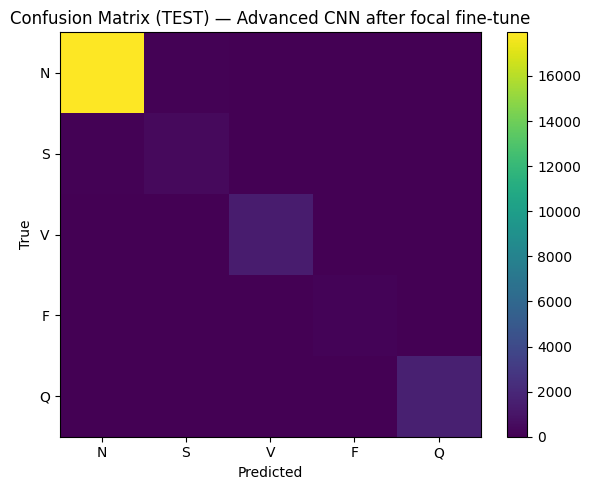

In [33]:
# Cell 26: Post-fine-tune evaluation & comparison

from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Pre-fine-tune baselines from Cells 19–21
pre_val_macro  = f1_score(y_val,  y_val_pred_adv_argmax,  average="macro")
pre_test_macro = f1_score(y_test, y_test_pred_adv_argmax, average="macro")

# After fine-tune
proba_val_ft  = model_ft.predict(ds_val,  verbose=0)
proba_test_ft = model_ft.predict(ds_test, verbose=0)
y_val_pred_ft  = proba_val_ft.argmax(axis=1)
y_test_pred_ft = proba_test_ft.argmax(axis=1)

post_val_macro  = f1_score(y_val,  y_val_pred_ft,  average="macro")
post_test_macro = f1_score(y_test, y_test_pred_ft, average="macro")

print(f"[VAL]  macro-F1: pre={pre_val_macro:.4f}  → post={post_val_macro:.4f}")
print(f"[TEST] macro-F1: pre={pre_test_macro:.4f} → post={post_test_macro:.4f}")

print("\n[VAL] report (post-finetune):")
print(classification_report(y_val, y_val_pred_ft, target_names=["N","S","V","F","Q"], digits=4))
print("\n[TEST] report (post-finetune):")
print(classification_report(y_test, y_test_pred_ft, target_names=["N","S","V","F","Q"], digits=4))

# (Optional) Confusion matrix on test
cm = confusion_matrix(y_test, y_test_pred_ft, labels=[0,1,2,3,4])
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(cm, aspect='auto')
plt.title("Confusion Matrix (TEST) — Advanced CNN after focal fine-tune")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
plt.colorbar(); plt.tight_layout(); plt.show()


In [34]:
# Save final fine-tuned model & reports
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report

final_path = PROJ / "models" / "ecg_cnn_advanced_focal_final.keras"
model_ft.save(final_path)
print("Saved:", final_path)

# Save predictions & reports
np.save(RESULTS / "dl_adv_focal_val_pred.npy",  y_val_pred_ft)
np.save(RESULTS / "dl_adv_focal_test_pred.npy", y_test_pred_ft)

rep_val  = classification_report(y_val,  y_val_pred_ft,  target_names=["N","S","V","F","Q"], digits=4)
rep_test = classification_report(y_test, y_test_pred_ft, target_names=["N","S","V","F","Q"], digits=4)
with open(RESULTS / "dl_adv_focal_report_val.txt", "w") as f: f.write(rep_val)
with open(RESULTS / "dl_adv_focal_report_test.txt", "w") as f: f.write(rep_test)
print("Saved reports to:", RESULTS)


Saved: C:\Users\nikhi\Music\ECG\models\ecg_cnn_advanced_focal_final.keras
Saved reports to: C:\Users\nikhi\Music\ECG\results


In [39]:
# Final DL-only Leaderboard (clean version — only full table printed)
import os, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score

rows = []

def add_row(name, y_pred, y_true):
    macro = f1_score(y_true, y_pred, average="macro")
    per = [f1_score((y_true==c).astype(int), (y_pred==c).astype(int), zero_division=0) for c in range(5)]
    rows.append({
        "model": name,
        "test_macro_f1": macro,
        "test_f1_N": per[0], "test_f1_S": per[1],
        "test_f1_V": per[2], "test_f1_F": per[3], "test_f1_Q": per[4],
    })

assert 'y_test' in globals(), "y_test not found."

# 1) CNN Advanced + Focal (final)
added_any = False
try:
    if 'y_test_pred_ft' in globals():
        add_row("CNN Advanced + Focal", y_test_pred_ft, y_test)
        added_any = True
    else:
        from tensorflow.keras.models import load_model
        mdl = load_model(PROJ / "models" / "ecg_cnn_advanced_focal_final.keras")
        yp = mdl.predict(ds_test, verbose=0).argmax(axis=1)
        add_row("CNN Advanced + Focal", yp, y_test)
        added_any = True
except Exception as e:
    print("Skip Advanced+Focal (not found):", e)

# 2) CNN Advanced (pre-finetune)
try:
    from tensorflow.keras.models import load_model
    adv_best = PROJ / "models" / "ecg_cnn_advanced_best.keras"
    if adv_best.exists():
        mdl_adv = load_model(adv_best)
        yp_adv = mdl_adv.predict(ds_test, verbose=0).argmax(axis=1)
        add_row("CNN Advanced (pre-finetune)", yp_adv, y_test)
        added_any = True
except Exception as e:
    print("Skip Advanced (pre-finetune):", e)

# 3) CNN Baseline (GAP→Softmax)
try:
    p = RESULTS / "cnn_baseline_test_pred.npy"
    if p.exists():
        y_pred_base = np.load(p)
        add_row("CNN Baseline (GAP→Softmax)", y_pred_base, y_test)
        added_any = True
except Exception as e:
    print("Skip CNN Baseline:", e)

if not added_any:
    raise RuntimeError("No DL artifacts found. Ensure you've run evaluations/saves earlier.")

leaderboard = pd.DataFrame(rows).sort_values("test_macro_f1", ascending=False, ignore_index=True)
display(leaderboard.round(4))

out_csv = RESULTS / "final_leaderboard_dl.csv"
leaderboard.to_csv(out_csv, index=False)
print("Saved:", out_csv)


,model,test_macro_f1,test_f1_N,test_f1_S,test_f1_V,test_f1_F,test_f1_Q
0,CNN Advanced + Focal,0.9130,0.9911,0.8175,0.9566,0.8080,0.9919
1,CNN Advanced (pre-finetune),0.9094,0.9912,0.8204,0.9552,0.7900,0.9904
2,CNN Baseline (GAP→Softmax),0.8454,0.9840,0.6858,0.9171,0.6621,0.9782


Saved: C:\Users\nikhi\Music\ECG\results\final_leaderboard_dl.csv


In [38]:
# Save a textual summary of the final model (UTF-8 safe) + parameter count
from contextlib import redirect_stdout
import io, json, numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

summary_buf = io.StringIO()
model_ft.summary(print_fn=lambda s: summary_buf.write(s + "\n"))
summary_text = summary_buf.getvalue()

# Write with UTF-8 explicitly; fallback to 'replace' if something still trips
summary_path = RESULTS / "dl_final_model_summary.txt"
try:
    with open(summary_path, "w", encoding="utf-8") as f:
        f.write(summary_text)
except UnicodeEncodeError:
    with open(summary_path, "w", encoding="utf-8", errors="replace") as f:
        f.write(summary_text)
print("Saved:", summary_path)

# Parameter count
total_params = int(
    np.sum([K.count_params(w) for w in model_ft.trainable_weights + model_ft.non_trainable_weights])
)
with open(RESULTS / "dl_final_model_params.json", "w", encoding="utf-8") as f:
    json.dump({"total_params": total_params}, f, indent=2, ensure_ascii=False)
print("Saved:", RESULTS / "dl_final_model_params.json", "| total_params:", total_params)


Saved: C:\Users\nikhi\Music\ECG\results\dl_final_model_summary.txt
Saved: C:\Users\nikhi\Music\ECG\results\dl_final_model_params.json | total_params: 249837
